# Soft-Actor Critic

In [1]:
# From Computer vision lab 6, keeps reloading the code for the objects so that you can work on them without needing to reload the kernal
%load_ext autoreload
%autoreload 2
SAVE_PATH=''

In [2]:
# for colab
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Notebooks/DRL/DRL Coursework/'

import sys
sys.path.append(path)

SAVE_PATH=path

Mounted at /content/drive


In [3]:
# imports
from helpers.get_available_actions import get_available_actions, adv_action_from_index
import numpy as np
from helpers.advanced_map import AdvancedMap
import matplotlib.pyplot as plt
%matplotlib inline
import random
import torch
import math
import pickle
from collections import namedtuple, deque

# determine if we are using cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# tuple from page 3, part 3.1 of https://arxiv.org/pdf/1801.01290.pdf
# state space
# action space
# state_transition_probability is initially unknown, s*s*a
# reward amount
MDP_tuple = namedtuple('MDP_tuple', ['state', 'action', 'next_state', 'reward', 'done'])
# from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

In [5]:
# Build the Deep Q Network
class DQN(torch.nn.Module):
    """Deep Q Network, sizes based upon the grid search in RLLib"""

    def __init__(self):
        """Create an instance of the network"""
        # Call the base objects init method
        super().__init__()

        # our advanced network will be sending in a 53 column list of numbers
        self.dense1 = torch.nn.Linear(53, 256)
        # normalise the data in the network
        self.norm1 = torch.nn.BatchNorm1d(256)

        self.dense2 = torch.nn.Linear(256, 256)
        self.norm2 = torch.nn.BatchNorm1d(256)

        self.dense3 = torch.nn.Linear(256, 256)
        self.norm3 = torch.nn.BatchNorm1d(256)

        # 5 potential actions
        self.dense4 = torch.nn.Linear(256, 5)

    def forward(self, x):
        """Pass the data through the network"""
        # convert the input data to a float, run it through the first dense layer, then through the first batch norm layer and then apply the relu function
        output = torch.functional.F.relu(self.norm1(self.dense1(x.float())))
        # repeat for 
        output = torch.functional.F.relu(self.norm2(self.dense2(output)))

        output = torch.functional.F.relu(self.norm3(self.dense3(output)))
        # reshape the tensor and pass it through the last stage
        return self.dense4(output.view(output.size(0), -1))

In [10]:
class Pi(torch.nn.Module):
    """Need to work out whether to explore or not"""

    def __init__(self):
        """Create an instance of the network"""
        # Call the base objects init method
        super().__init__()
        # our advanced network will be sending in a 53 column list of numbers
        self.dense1 = torch.nn.Linear(53, 256)
        # normalise the data in the network
        self.norm1 = torch.nn.BatchNorm1d(256)

        self.dense2 = torch.nn.Linear(256, 256)
        self.norm2 = torch.nn.BatchNorm1d(256)

        self.dense3 = torch.nn.Linear(256, 256)
        self.norm3 = torch.nn.BatchNorm1d(256)

        # 2 potential policies, exploit or explore
        self.dense4 = torch.nn.Linear(256, 1)
    
    def forward(self, x):
        """Pass the data through the network"""
        # convert the input data to a float, run it through the first dense layer, then through the first batch norm layer and then apply the relu function
        output = torch.functional.F.relu(self.norm1(self.dense1(x.float())))
        # repeat for 
        output = torch.functional.F.relu(self.norm2(self.dense2(output)))

        output = torch.functional.F.relu(self.norm3(self.dense3(output)))
        # reshape the tensor and pass it through the last stage
        return torch.sigmoid(self.dense4(output.view(output.size(0), -1)))

In [7]:
class ReplayMemory(object):
    """from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"""
    def __init__(self, capacity):
        # uses a deque structure so that as new items are added to the end of the 'list' items at the front are pushed off of it
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(MDP_tuple(*args))

    def sample(self, batch_size):
        """Return a random sample from the memory"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def reset(self):
        """Clear the memories"""
        # reset the memory
        self.memory = deque([], maxlen=self.memory.maxlen)

In [8]:
def select_action(state, steps_done, policy) -> torch.tensor:
    """Inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html.
    Takes in the current state and the number of steps and returns an action either from the network or a random action"""

    # if the random number is bigger than the threshold then work out an action from the network
    if policy > 0.5:
        # don't work out the gradient for this
        with torch.no_grad():
            # get the max column value, then gets its index and reshape into the expected format
            return Q_net(state).max(1)[1].view(1, 1)
    # as there is a return in the if statement we don't need an else. return a random number between 0-4 and put it in the right shaped tensor
    return torch.tensor([[random.randrange(5)]], device=device, dtype=torch.long)

In [28]:
# using https://spinningup.openai.com/en/latest/algorithms/sac.html

# setup the networks and send them to the device
Q_net = DQN().to(device)
Q_target = DQN().to(device)
# load the state dictionary of weights from the q network to the target
Q_target.load_state_dict(Q_net.state_dict())
# set the target to evaluation mode
Q_target.eval()

# setup the optimiser
Q_optim = torch.optim.SGD(Q_net.parameters(), lr=0.01)

Policy_net = Pi().to(device) # theta
#Policy_target = Pi().to(device)
#Policy_target.load_state_dict(Policy_net.state_dict())

P_optim = torch.optim.SGD(Policy_net.parameters(), lr=0.01)

# from table 1
capacity = 10000
discount = 0.99 # γ

D = ReplayMemory(capacity)
num_updates = 20
BATCH_SIZE = 256

ALPHA = 1 # TODO find a less random number
GAMMA = 0.9

mean_rewards = []

TARGET_UPDATE = 1

for episode in range(1, 11):
    # fill up buffer with random actions
    D.reset()
    Q_net.eval()

    rewards = []

    while len(D) < capacity:
        # fill it up
        # Get an instance of the map
        amap = AdvancedMap()
        # Get the normalised observations
        obs, reward, done = amap.convert_observations(amap.reset())

        # setup the total reward
        total_reward = 0

        steps_done = 0
        Policy_net.eval()

        # run until it is done
        while not done:
            # put the state into a tensor
            state = torch.from_numpy(obs).unsqueeze(0)
            
            # pick an action and increment the number of steps
            pol = Policy_net(state)
            pol = pol.item()
            action, steps_done = select_action(state, steps_done, pol), steps_done + 1
            
            # get the action
            action = adv_action_from_index(action.item())

            # take the action
            next_state, reward, done = amap.convert_observations(amap.step(action))

            # add to the reward
            total_reward += reward

            # set next state to nothing if we're done
            if done:
                next_state = None
            
            # add to the memories
            # namedtuple('MDP_tuple', ['state', 'action', 'next_state', 'reward'])
            D.push(obs, torch.tensor([action.index], device=device), next_state, torch.tensor([float(reward)], device=device), done)

            # pass the next_state through to the next round
            obs = next_state
        rewards.append(total_reward)
    # start updating
    for j in range(num_updates):
        Policy_net.train()
        # get a batch of transitions from D
        transitions = D.sample(BATCH_SIZE)
        # convert the batch of transitions to a transition of batches
        batch = MDP_tuple(*zip(*transitions))


        # compute a mask of non-final states
        #non_final_mask = torch.tensor(tuple(map(lambda state: state is not None, batch.next_state)), device=device, dtype=torch.bool)

        # get the next states
        non_final_next_states = torch.cat([torch.tensor([s], device=device) for s in batch.next_state if s is not None])

        state_batch = torch.cat([torch.tensor([s], device=device) for s in batch.state])
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        action_batch = action_batch.reshape((BATCH_SIZE, 1))

        # compute target for the Q functions
        y = torch.zeros(BATCH_SIZE, device=device)

        targ = Q_target(non_final_next_states).min(1)[0].detach()
        targ = torch.reshape(targ, (len(non_final_next_states), 1))
        y = torch.reshape(targ - ALPHA * torch.log(Policy_net(non_final_next_states)), (len(non_final_next_states),))

        # shape y to fill the gaps
        ty = y.tolist()
        lst = 0
        y = []
        for ns in batch.next_state:
            if ns is None:
                y.append(0)
            else:
                y.append(ty[lst])
                lst = lst + 1
        y = torch.tensor(y, device=device)
        y = reward_batch + (GAMMA * y)

        # Update Q-functions by one step of gradient descent
        # work out the Q values
        q_vals = Q_net(state_batch).gather(1, action_batch)
        q_loss = torch.functional.F.mse_loss(q_vals, y)

        # optimise the Q_model
        Q_optim.zero_grad()
        q_loss.backward()

        # clip the gradients
        for param in Q_net.parameters():
            param.grad.data.clamp_(-1, 1)
        Q_optim.step()

        # Policy's turn (line 14 of https://spinningup.openai.com/en/latest/algorithms/sac.html#pseudocode)
        # update policy by 1 step of gradient ascent
        p_loss = torch.mean(Q_net(state_batch) - ALPHA * torch.log(Policy_net(state_batch)))

        # optimise the policy model
        P_optim.zero_grad()
        p_loss.backward()
        P_optim.step()
    # append mean of rewards to mean_rewards
    m_reward = np.mean(rewards)
    mean_rewards.append(m_reward)
    # update the target
    if episode % TARGET_UPDATE == 0:
        Q_target.load_state_dict(Q_net.state_dict())
    print(f"Episode {episode}, mean reward: {m_reward}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 1, mean reward: -70.57281553398059
Episode 2, mean reward: -100.50980392156863
Episode 3, mean reward: -94.13725490196079
Episode 4, mean reward: -100.0
Episode 5, mean reward: -100.36633663366337
Episode 6, mean reward: -101.58035714285714
Episode 7, mean reward: -100.31683168316832
Episode 8, mean reward: -83.12621359223301
Episode 9, mean reward: -100.59803921568627
Episode 10, mean reward: -100.0


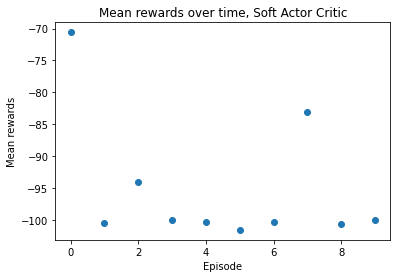

In [29]:
# plot the rewards per episode
plt.scatter(list(range(len(mean_rewards))), mean_rewards)
plt.title("Mean rewards over time, Soft Actor Critic")
plt.xlabel("Episode")
plt.ylabel("Mean rewards")
plt.show()

In [30]:
# Save the data
with open(SAVE_PATH + 'data/SAC/rewards.pkl', 'wb') as f:
    # serialise the rewards array
    pickle.dump(mean_rewards, f)
# save the state dict (from https://pytorch.org/tutorials/beginner/saving_loading_models.html)
torch.save(Q_net.state_dict(), SAVE_PATH + 'data/SAC/qnet.pth')
torch.save(Policy_net.state_dict(), SAVE_PATH + 'data/SAC/policynet.pth')